## Imports

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import os
import random
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Visualizing the images

In [34]:
classes = ['angry', 'disgust', 'fear','happy', 'neutral' ,'sad', 'surprise']
num_classes = len(classes)

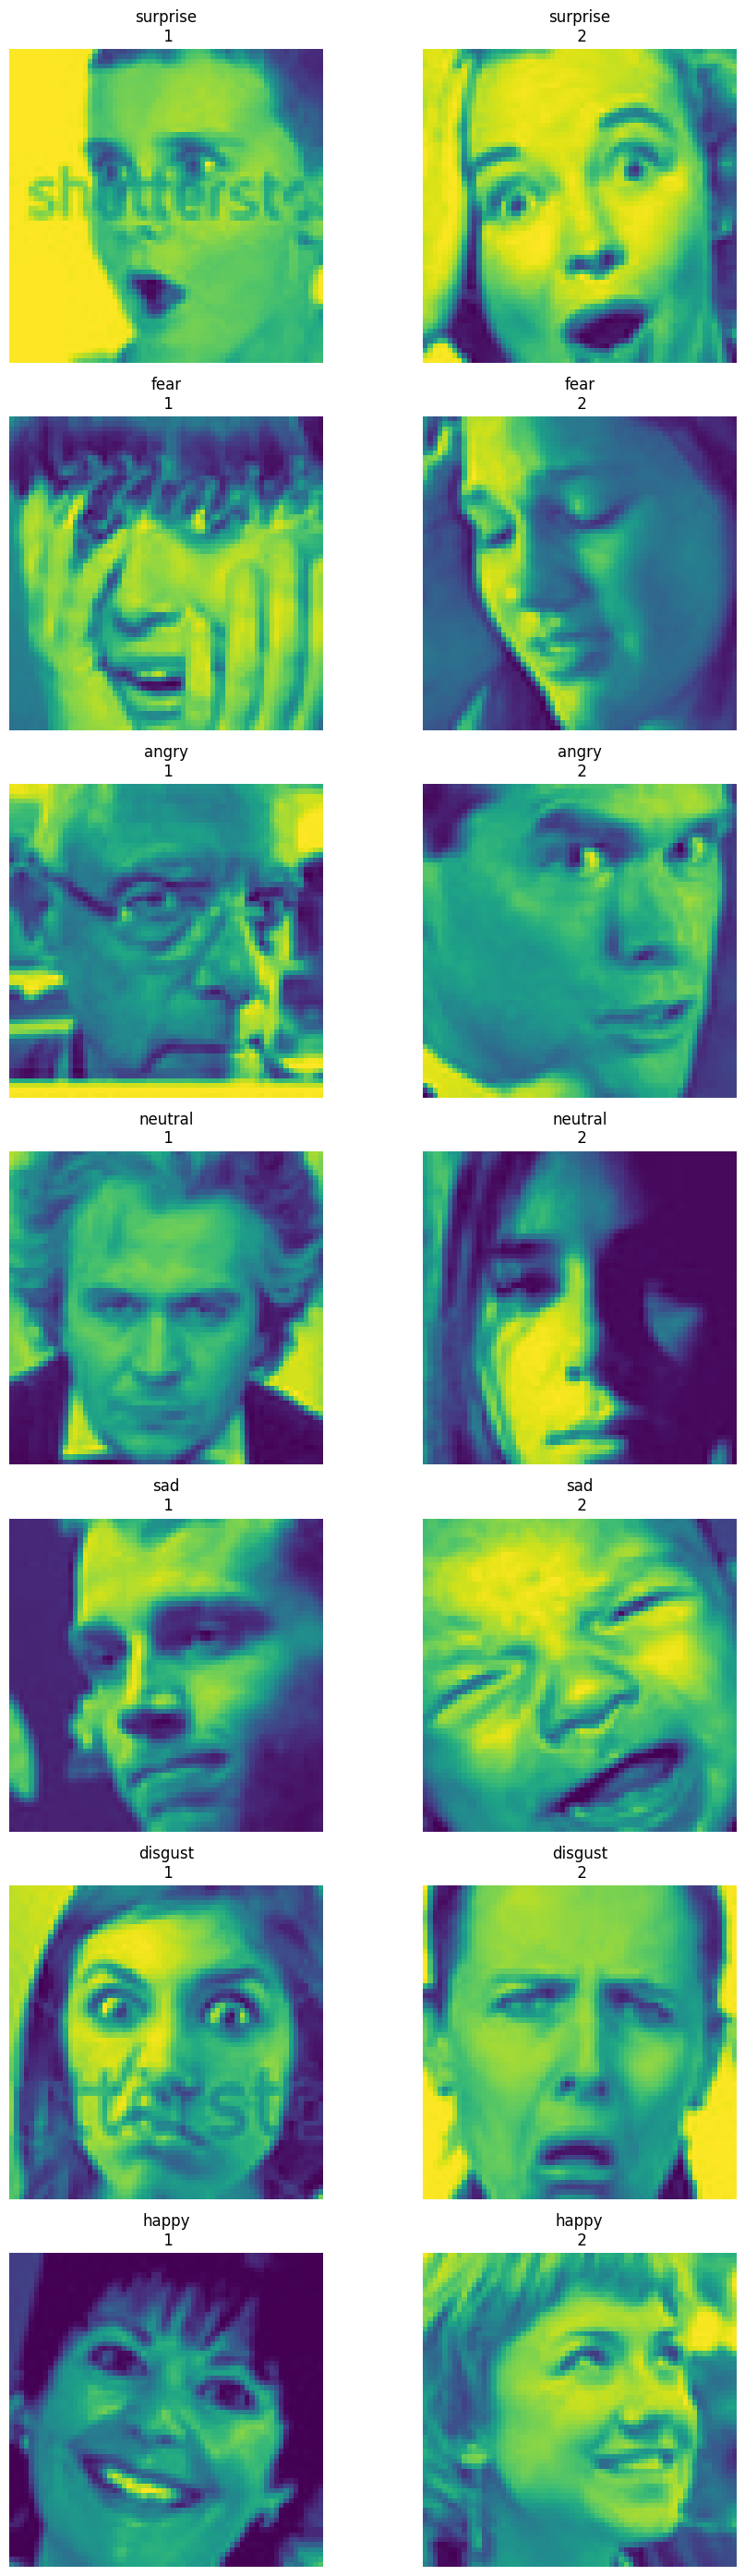

In [26]:
## Train images
def visualize(directory, images=2):
    subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

    # Plot the selected images
    plt.figure(figsize=(10, 4 * len(subfolders)))
    
    for i, subfolder in enumerate(subfolders, 1):
        subfolder_path = os.path.join(directory, subfolder)
        image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Randomly select required no of images from each subfolder
        selected_images = random.sample(image_files, min(images, len(image_files)))

        # Plot the selected images from the current subfolder
        for j, image_file in enumerate(selected_images, 1):
            image_path = os.path.join(subfolder_path, image_file)
            img = Image.open(image_path)
            img = img.resize((64,64))
            
            plt.subplot(len(subfolders), images, (i - 1) * images + j)
            plt.imshow(img)
            plt.title(f"{subfolder}\n {j}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

train_directory = '/kaggle/input/fer2013/train'
visualize(train_directory,images=2)

## Data Preprocessing

In [27]:
img_size = 224
batch_size = 64

In [28]:
train_preprocessor = ImageDataGenerator(
        rescale = 1/255.0,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest')

test_preprocessor = ImageDataGenerator(
        rescale = 1/255.0)

In [29]:
train = train_preprocessor.flow_from_directory(
        '/kaggle/input/fer2013/train',
        class_mode="categorical",
        target_size=(img_size, img_size),
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size,
        subset='training')

test = test_preprocessor.flow_from_directory(
        '/kaggle/input/fer2013/test',
        class_mode='categorical',
        target_size=(img_size, img_size),
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [30]:
resnet = ResNet50V2(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet')

94668760/94668760 [==============================] - 0s 0us/step


In [31]:
resnet.trainable = True
for layer in resnet.layers[:-20]:
    layer.trainable = False

In [35]:
## Creating the model
model = Sequential()
model.add(resnet)
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
## Callbacks
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor = 0.2, min_lr = 0.00005, verbose=1)

callbacks = [early_stopping, reduce_lr]
steps_per_epoch = train.n // train.batch_size
validation_steps = test.n // test.batch_size

In [41]:
history = model.fit(train, validation_data=test, epochs=20, batch_size=batch_size, callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 472s 1s/step - loss: 1.2227 - accuracy: 0.5462 - val_loss: 1.1201 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 396s 883ms/step - loss: 1.1230 - accuracy: 0.5825 - val_loss: 1.0787 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 379s 846ms/step - loss: 1.0576 - accuracy: 0.6080 - val_loss: 1.0914 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 378s 843ms/step - loss: 1.0173 - accuracy: 0.6252 - val_loss: 1.0205 - val_accuracy: 0.6183 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 376s 838ms/step - loss: 0.9796 - accuracy: 0.6386 - val_loss: 1.0616 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.6495
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [==========================

## Model Evaluation

In [42]:
loss, accuracy = model.evaluate(test)

113/113 [==============================] - 22s 191ms/step - loss: 1.0026 - accuracy: 0.6683


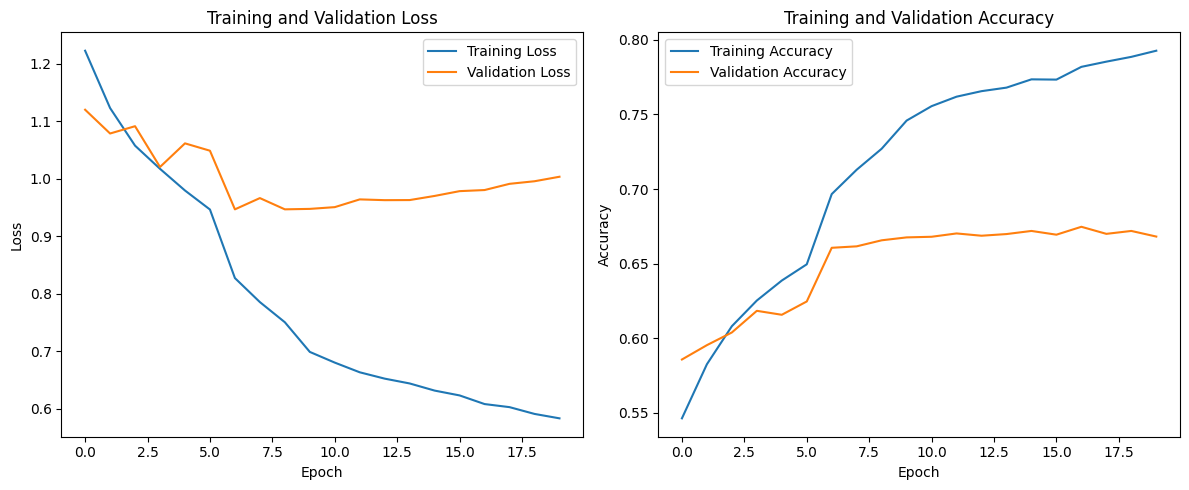

In [44]:
## Plotting loss and accuracy
def plot_loss_accuracy(history):
    # Plot training loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

## Making predictions

113/113 [==============================] - 20s 181ms/step


Text(0.5, 1.0, 'Confusion Matrix')

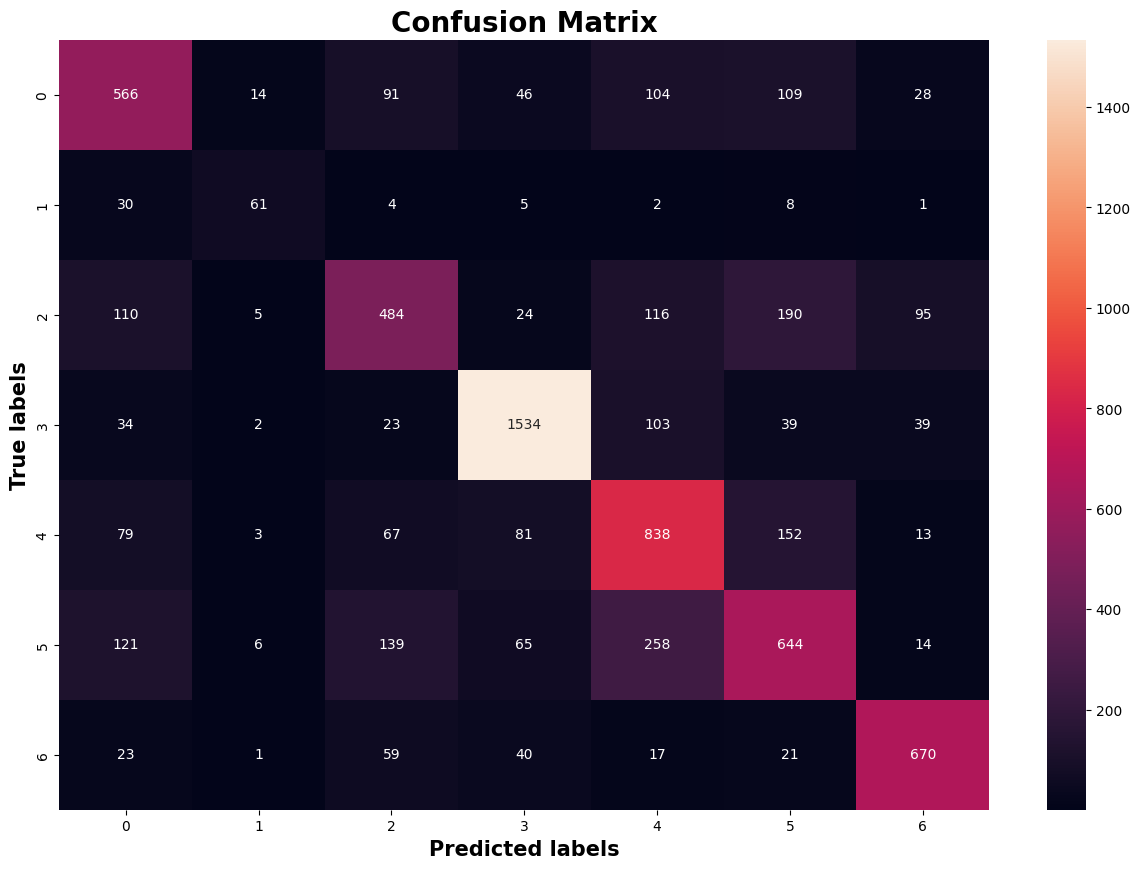

In [47]:
predictions = np.argmax(model.predict(test), axis=1)

fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test.labels, predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=20, fontweight='bold')

## Model inference

1/1 [==============================] - 0s 21ms/step


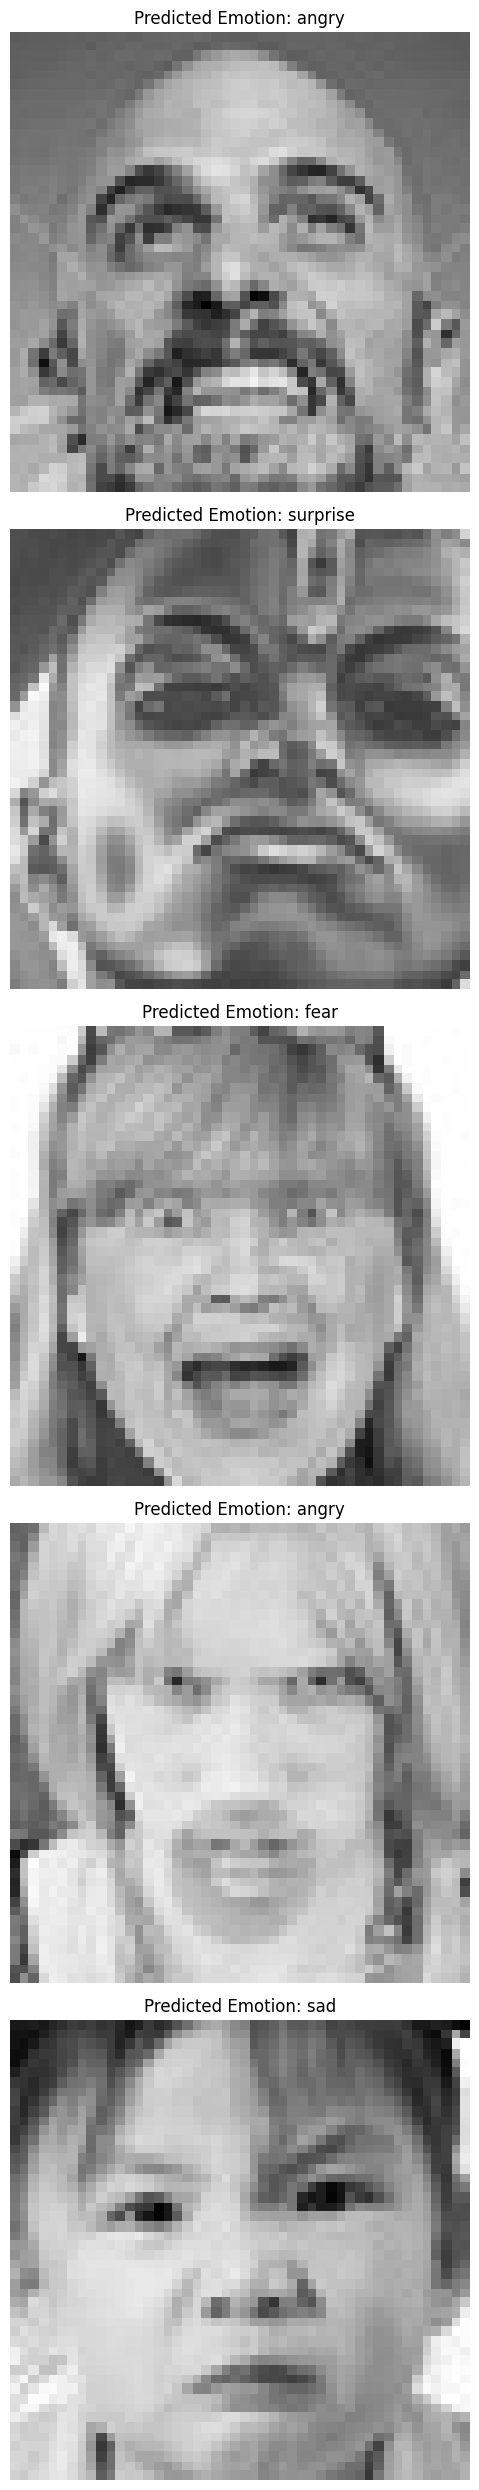

In [60]:
def predict_emotion(model, image):
    # Make prediction
    prediction = model.predict(image)
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]

    return predicted_emotion

def visualize_inference(model, test_iterator, num_samples=5):
    # Get a batch of test images and their corresponding labels
    images, _ = test_iterator.next()

    # Make predictions for the batch of test images
    predictions = model.predict(images)

    # Plot the selected images and their predictions
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Get the predicted emotion for the current image
        predicted_emotion = predict_emotion(model, images[i:i+1])

        # Display the image and predicted emotion
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(images[i], cmap='gray', interpolation='nearest') 
        plt.title(f"Predicted Emotion: {predicted_emotion}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_inference(model, test, num_samples=5)

In [61]:
model.save('resnet_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
